In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import mpld3
import seaborn as sn
import pandas as pd
import numpy as np
import imp
import scipy.stats as st
import statsmodels.api as sm
import statsmodels.formula.api as smf

sn.set_context('talk')

In [2]:
# Optionally suppress warnings in the final version of the notebook
import warnings
warnings.filterwarnings('ignore')

# ECOREG full analysis (part 3: relationships)

This notebook follows on from the work described [here](http://nbviewer.jupyter.org/github/JamesSample/ECOREG/blob/master/ecoreg_full_analysis_1.ipynb) and [here](http://nbviewer.jupyter.org/github/JamesSample/ECOREG/blob/master/ecoreg_full_analysis_2.ipynb). In the first notebook, PCA was used to identify a subset of potentially interesting parameters with reduced collinearity; in the second, potentially interesting patterns highlighted by the PCA were explored by testing for differences between regulated and unregulated sites. In this notebook, I want to explore regression relationships between the variables, following up on hypotheses developed in notebooks 1 and 2.

In [3]:
# Read basic datasets

# Hydro indicators
in_xls = r'C:\Data\James_Work\Staff\Susi_S\ECOREG\Stats_Input_Data\hydro_indic.xlsx'
hi_df = pd.read_excel(in_xls, sheetname='hydro_indic', index_col=0)
hi_df = hi_df.query('(eco_dataset == "pb") and (time_per == 3)')

# Site props
in_xls = r'C:\Data\James_Work\Staff\Susi_S\ECOREG\Stats_Input_Data\site_props.xlsx'
site_df = pd.read_excel(in_xls, sheetname='site_props', index_col=0)

# MZB
in_xls = r'C:\Data\James_Work\Staff\Susi_S\ECOREG\Stats_Input_Data\mzb_chem_ecol.xlsx'
mzb_df = pd.read_excel(in_xls, sheetname='mzb_data', index_col=0)

# PB
in_xls = r'C:\Data\James_Work\Staff\Susi_S\ECOREG\Stats_Input_Data\pb_chem_ecol.xlsx'
pb_df = pd.read_excel(in_xls, sheetname='pb_data', index_col=0)

In [4]:
# Added 27/07/2017
# Daniel recommends removing German site 107002711
# from the analysis (see e-mail from Susi received 30/05/2017 at 11.20)
hi_df = hi_df[hi_df.index != 107002711]
site_df = site_df[site_df.index != 107002711]
mzb_df = mzb_df[mzb_df.index != 107002711]
pb_df = pb_df[pb_df.index != 107002711]

In [5]:
# Import custom functions
func_path = r'C:\Data\James_Work\Staff\Susi_S\ECOREG\Python\ECOREG\final_analysis\ecoreg_code.py'

ecoreg = imp.load_source('ecoreg_code', func_path)

## 6. Relationships to explore

Based on the results in the previous two notebooks, variables have been selected because either: 

 1. They are broadly representative of the principal components in the ecology, water quality or hydrology datasets ([notebook 1](http://nbviewer.jupyter.org/github/JamesSample/ECOREG/blob/master/ecoreg_full_analysis_1.ipynb)), and/or <br><br>
 
 2. They show potentially interesting differences between regulated and unregulated sites ([notebook 2](http://nbviewer.jupyter.org/github/JamesSample/ECOREG/blob/master/ecoreg_full_analysis_2.ipynb)).
 
The aim of this notebook is to explore regression relationships between these variables. 

## 7. Regression approaches

Despite the data exploration and dimensionality reduction in the previous two notebooks, we still have a reasonably large number of response and explanatory variables. Furthermore, we are primarily interested in identifying and understanding the key relationships between these variables, rather than just making predictions for future outcomes. For this reason, it is important that the statistical models created are interpretable (at least to some extent), rather than being mysterious "black boxes".

Modern statistical techniques such as regression trees, neural networks etc. have the ability to deal well with non-linear relationships, and they often have excellent predictive performance too. Unfortunately, they are also generally difficult to interpret, and for this reason I have **restricted this analysis to linear models only** (time is tight and linear models are complicated enough!). In reality, the relationships in our data are unlikely to be linear, but I hope there will be some interesting patterns to discover nevertheless.

Even considering a restricted set of candidate model structures, the problem of variable selection to identify "scientifically significant" relationships is still very challenging. In this notebook I'll try a number of different methods in an attempt to build up a consistent picture. I'm not sure whether this workflow is well established, but I believe it should be reasonably robust. My method is as follows:

 1. Use the best fitting **lasso model** (obtained via cross-validation), together with an exploration of the **lasso path**, to understand the most important relationships in the dataset. Note that the lasso model must be estimated using **standardised** varaibles. (An excellent description of how to interpret the lasso path can be found [here](http://stats.stackexchange.com/a/154853/5467)). <br><br>
 
 2. Use the results from (1) to guide construction of a few relevant OLS models using the non-standardized (and therefore easier to interpret) values. <br><br>
 
 3. Use **best subsets** regression to identify the model with the lowest BIC of all the models under consideration. Note that, like stepwise regression, this basically amounts to "data dredging" and therefore cannot be taken too seriously. On the other hand, these techniques are widely used, so they make a useful comparison to the lasso output.

**Note:** Best subsets and stepwise regression techniques involve testing large numbers of different models in an attempt to identify the "best" (where "best" is often defined as the model with the lowest AIC or BIC). In the context of "significance" testing, these methods have been heavily criticised, because the p-values and parameter estimates obtained are essentially meaningless (see [notebook 1](http://nbviewer.jupyter.org/github/JamesSample/ECOREG/blob/master/ecoreg_full_analysis_1.ipynb) for more details). In essence, trying a very large number of different models is prone to "overfitting" for exactly the same reasons that very complex models are: we know that our measured dataset includes some random components, and if we try enough different models we'll eventually find one that just happens to fit well with the randomness in our data. We therefore observe excellent within-sample model performance, but we're actually fitting the noise rather than the signal, so the "best" model found by stepwise or best subsets methods will often perform poorly out-of-sample (i.e. it's not actually a good model at all). Simulation studies - where the true model is known exactly - have repeatedly shown that these techniques can select completely the wrong model, even when the assumptions (e.g. regarding the error structure) are properly satisfied.  

In most cases, best subsets and stepwise regression approaches are inappropriate and the recommended approach is instead to use some kind of **regularisation**, such as **ridge** regression or the **lasso**. Ridge regression has advantages when there are lots of collinear predictors, whereas the lasso incorporates "feature selection" and can be useful when the aim is to produce a parsimonious (i.e. "sparse") model, which may be eaiser to interpret. In [notebook 1](http://nbviewer.jupyter.org/github/JamesSample/ECOREG/blob/master/ecoreg_full_analysis_1.ipynb), I used PCA to reduce colinearity: the principal components are orthogonal (and therefore by definition not collinear), so ridge regression should not be necessary. In actual fact, I haven't completely removed collinearity from our data, because I decided to work with the explanatory variables with the highest loading along each of the PCs, rather than with the PCs directly. This was done to make the output easier to interpret. Nevertheless, I hope to have reduced collinearity by a substantial degree, so in this analysis I will focus on the use of lasso regression for the purpose of variable selection and interpretation.

Finally, note that regularised regression has a natural interpretation within a Bayesian context: ridge regression is equivalent to using a Gaussian prior on the parameters, whereas lasso assumes a Laplace prior. For convenience, I am not explicitly formulating these regressions within a Bayesian framework, but the work presented here is not incompatible with the Bayesian approach used in [notebook 2](http://nbviewer.jupyter.org/github/JamesSample/ECOREG/blob/master/ecoreg_full_analysis_2.ipynb).

### 7.1. Interpretation

For this kind of regression analysis, we generally assume that:

 * Correlation does not imply causation, **but** <br><br>
 
 * Significant correlation plus a plausible causal mechanism is suggestive of something scientifically interesting.
 
The previous two notebooks identified a range of candidate explanatory variables, almost all of which could plausibly influence the ecological response. The aim of this analysis is to try to infer which explanatory factors are the most important (especially regarding e.g. water chemistry versus hydrology).

The standard reference for characterising causal relationships mathematically is Judea Pearle's classic textbook "[Causality](http://bayes.cs.ucla.edu/BOOK-2K/)". One day I will find time to read this properly, but at present my understanding is superficial. In simplistic terms, relationships between the response and the predictor may occur in the following ways:

 1. **The predictor directly causes the response**. This is what we're most interested in. It is tempting to think that the predictor with the strongest relationship to the response is the most likely to have a direct effect, but **this is not true** (although it may be a useful heuristic/discussion point). There are some interesting additional considerations [here](http://stats.stackexchange.com/questions/534/under-what-conditions-does-correlation-imply-causation) and [here](http://stats.stackexchange.com/questions/26300/does-causation-imply-correlation).  <br><br>
 
 2. **By random chance**. If you repeatedly generate sets of random numbers and regress them on each other, you will occasionally see "significant" correlations between them. This is what p-values guard against: they give the probabltiy of observing a relationship as strong as the one in your data purely by chance. By setting a threshold at e.g. p=0.05, you're essentially saying, "*a relationship this strong is unlikely to occur just by chance*". (Of course, this assumes you only performed a single statistical test - if you used best subsets or stepwise regression to pick the model, you may have already tried a large number of regressions, in which case p-values are difficult to interpret meaningfully). <br><br>
 
 3. **There is an indirect relationship between the predictor and the response**. When the explanatory variables are collinear, as is the case in our dataset, this situation is very likely. [This quote](http://stats.stackexchange.com/a/121577/5467) is useful:
 
   > An association between a variable Y and an outcome Z reflects a causal relationship between Y and Z *if there are no open "backdoor paths" between Y and Z*.

  The simplest example is shown below (but real cases are usually more complex):
  
<img src="https://cdn-images-1.medium.com/max/1600/1*oTQVofKLGy0mqaNiU9P7Bw.png" alt="Basic causal graph" width="600">
  
  Z is the response variable and X and Y are possible predictors. Y causes Z and X causes Y, but (assuming the relationship is linear) both X and Y will be correlated with Z. The regression models `Z ~ Y` and `Z ~ X` will therefore both be significant. However, one of the variables in the model `Z ~ X + Y` will **not** be significant because, having accounted for one of them, the other is no longer important. In an ideal situation, Y would be "more significant" than X, in which case we might drop X, find that the BIC of the model improves and ultimately recover the true model (`Z ~ Y`). In reality, of course, it's rarely this simple. 
  
  Note that it is also possible (and in fact likely) that the true cause of an ecological response is not represented in our explanatory variables *at all* (e.g. we might measure X, but not Y). In this case, the best model we can find given our dataset is `Z ~ X`, but we must be wary of drawing the (incorrect) conclusion that X causes Z.
  
Keeping all this in mind during the analysis below will not be easy, but I'll try.
  
### 7.2. Example from Norway

The easiest way to introduce the regression workflow is with a detailed example. Afterwards I'll just present summary results for the other variables.

#### 7.2.1. Number of MZB taxa

We begin by extracting a dataframe containing the response variable (`n_taxa`) and explanatory variables of interest (from the table for Norway above).

In [6]:
cols = ['n_taxa', 'tn', 'toc', 'cond', 'mean', 'p50', 'max12',
        'revs_per_yr', 'days_to_p95', 'max10', 'days_to_max',
        'cv', 'av_fall_rt', 'range', 'country', 'regulated']
df = pd.concat([site_df, mzb_df, hi_df], axis=1)[cols]
df = df.query('country == "N"')

df.head()

,n_taxa,tn,toc,cond,mean,p50,max12,revs_per_yr,days_to_p95,max10,days_to_max,cv,av_fall_rt,range,country,regulated
S109.2,20.0,0.285,0.85,52.2,31.613410,16.02159,17.27617,132.000000,84,33.35955,828,1.405250,-4.683471,655.79835,N,1
S109.21,23.0,0.099,0.72,30.7,3.576798,1.79043,1.41556,138.333333,83,4.63132,827,1.340999,-0.597073,49.58114,N,0
S109.9,24.0,0.054,0.69,36.2,19.490855,6.62810,5.01335,120.333333,83,26.58150,827,1.507076,-3.001413,334.40153,N,0
S12.137,41.0,0.155,1.20,14.9,25.628777,18.88433,28.86813,176.333333,75,176.84978,822,0.914427,-3.796932,214.85086,N,1
S12.200,34.0,0.255,2.70,31.5,25.806984,14.76677,15.78188,97.666667,25,128.84639,111,1.411023,-3.871888,496.59644,N,1


##### Step 1: Plot the lasso path

In [7]:
# Lists of explan and resp vars
exp_vars = ['tn', 'toc', 'cond', 'mean', 'max12',
            'revs_per_yr', 'days_to_p95', 'max10', 'days_to_max',
            'cv', 'av_fall_rt', 'range', 'regulated']
resp_var = 'n_taxa'

# Plot lasso path
res_df, fig = ecoreg.plot_lasso_path(df, resp_var, exp_vars)

mpld3.display(fig)

This is a complicated plot, with some repeated colours. To identify which curve is which, hover the mouse pointer over the lines along the right-hand margin of the figure - "tooltip" labels should appear identifying each line.

The lasso is a form of **regularised regression**, which means a penalty is added which "shrinks" the regression coefficients towards zero (see [this notebook](http://nbviewer.jupyter.org/github/JamesSample/ECOREG/blob/master/ecoreg_prelim_analysis2.ipynb) for more details). The size of the regularisation penalty is controlled by *alpha*, which appears along the x-axis of the plot above (but it is rescaled as $-Log(alpha)$). Small values of $-Log(alpha)$ (the left side of the plot) correspond to very "heavy" regularisation, where all the parameter coefficents are forced to zero and the "best" model becomes the "null" model (i.e. a heavy penalty favours simpler models). As $-Log(alpha)$ becomes larger (moving rightwards on the x-axis), the regularisation becomes less severe and some of the parameter values for the best-fitting model become non-zero (i.e. the "best" model becomes more complex). At the extreme right edge of the plot, the regularisation penalty is very small, and the coefficient estimates approach those obtained using standard OLS regression (on the standardised data).

As the alpha penalty is relaxed (reading from left to right), parameters that come into the model first can be interpreted as being more important (i.e. of having a stronger relationship to the response variable). What's more, the shape of the lasso path for each variable provides information regarding any remaining collinearity between predictors.

The plot can be interpreted as follows:

 * The first variable to come into the model as the regularisation penalty is relaxed is `tn`. The coefficient value for `tn` is positive and it increases rapidly and remains high throughout the path, implying that `tn` is the most important variable (of those being considered), and that it is positively correlated with `n_taxa`. <br><br>

 * The next variable to enter the model (and therefore the next most important) is `cv`. The coefficient is negative and its magnitude also increases quite rapidly. This implies that more variable flow conditions have a negative effect on the number of MZB taxa. <br><br>

 * The next variable to enter the model is `cond`. However, note that when `cond` enters there is a sudden kink in the trace for `tn`. This implies that `tn` and `cond` are correlated with one another (i.e. they are collinear), so to some extent these two variables can substitute for one another in the model. From a physical perspective, it is not surprising that `tn` and `cond` are related. If we want to build a parsimonious model that is easier to interpret, we might therefore choose to keep `tn` but not `cond`, because `tn` has a stronger relationship with the response. <br><br>

 * The next variable to enter is `toc`. This may also have an effect on the trace for `tn` (suggesting more collinearity), but this isn't too obvious on this plot, so I'm tempted to keep `toc` in the model for now. <br><br>

 * The next parameter to enter is `days_to_max` which, perhaps surprisingly, has a negative coefficient. Shortly after this, `days_to_p95` enters with a positive coefficient. These are two very similar quantities and the fact they exhert influence in opposie directions seems dubious, and suggests we might be getting to the stage where the (increasingly complex) model is starting to fit noise in the data rather than a genuine signal. This may be an indication that it's time to stop adding variables. <br><br>

 * The next two parameters to enter are `revs_per_yr` and `mean`, the former entering with a negative coefficient and the latter with a positive one. This makes intuitive sense: larger rivers typically have more stable flow conditions (fewer reversals per year), and such stable conditions seem to favour more MZB taxa. However, the trace for `revs_per_yr` is broadly similar to that for `cv`, except the relationship is weaker. From a physical standpoint, both these metrics are indicators of flow variability, so I'm tempted to ignore `revs_per_yr` and keep `cv` in the model for further investigation.

Based on this, we can identify a more parsimonious model with just 4 explanatory variables. Let's look in more detail at the lasso paths for these.

In [8]:
# Lists of explan and resp vars
exp_vars = ['tn', 'cv', 'toc', 'mean']
resp_var = 'n_taxa'

res_df, fig = ecoreg.plot_lasso_path(df, resp_var, exp_vars)

mpld3.display(fig)

These paths are much smoother, but now that we're looking in more detail we can see an obvious kink in the `tn` trace (caused when `toc` enters the model), and a similar kink in `cv` (caused when `mean` enters the model). It looks as though there is collinearity here after all, so perhaps a better model still would be to drop `toc` and `mean` as well.

Overall, based on an analysis of the lasso paths, I conclude that:

 * `tn` is the explanatory variable with the strongest relationship to `n_taxa`: more N means more taxa. <br><br>
 
 * `cv` is also important: more variable flow conditions mean fewer taxa. <br><br>
 
 * Other variables - especially `toc` and `mean` - may also be important, but they appear to be significantly correlated with `tn` and `cv`, both of which are more strongly related to the response.
 
##### Step 2: Find the best lasso model 

Next, we use cross-validation to find the best (i.e. "most predictive") value for alpha. The coefficients for this model give an indication of which variables are genuinely important. 

(Note that the function I've created for this calculation has a number of plotting options, only some of which are described below).

LassoCV(alphas=None, copy_X=True, cv=3, eps=0.001, fit_intercept=False,
    max_iter=10000, n_alphas=100, n_jobs=1, normalize=False,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)


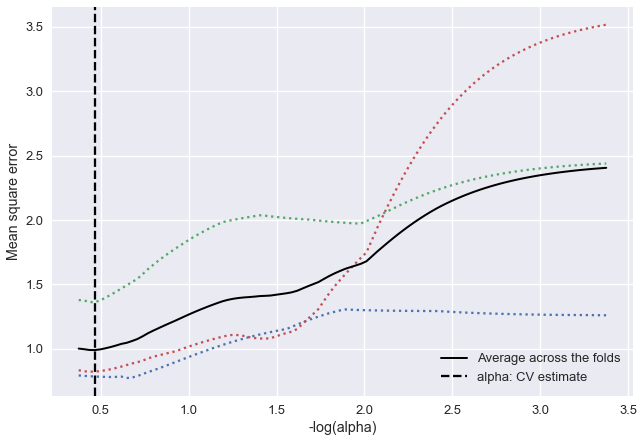

,0
tn,0.079675
toc,0.000000
cond,0.000000
mean,0.000000
max12,0.000000
revs_per_yr,-0.000000
days_to_p95,0.000000
max10,0.000000
days_to_max,-0.000000
cv,-0.000000


In [9]:
# Lists of explan and resp vars
exp_vars = ['tn', 'toc', 'cond', 'mean', 'max12',
            'revs_per_yr', 'days_to_p95', 'max10', 'days_to_max',
            'cv', 'av_fall_rt', 'range', 'regulated']
resp_var = 'n_taxa'

params = ecoreg.best_lasso(df, resp_var, exp_vars, kcv=3, cv_path=True, hists=False)
params

The minimum of the thick black line on the plot above gives the optimum value for alpha. This is the value with the lowest mean squared error as estimated by three-fold cross-validation. With this value for alpha, **the best model includes only `TN`** - all the other coefficients are set to zero. This is consistent with the discussion above.

**Note:** We have a fairly limited dataset (only 40 sites in Norway), which makes meaningful k-fold cross-validation quite difficult. The best model seems quite sensitive to different choices of $k$, although the general picture is still consistent with the discussion of the lasso path above.

##### Step 3: Explore some OLS alternatives

OLS results are familar to most people and are easier to interpret, in part because they can use the original units). It can therefore be useful/reassuring to explore some OLS output as well. Here's a model including `tn` and `cv` - the two main parameters identifed from the lasso path.

In [10]:
mod_str = 'n_taxa ~ cv + tn'

# Regression. Pass alpha=0 for OLS. Larger alpha gives a bigger penalty on the
# size of the parameter estimates
model = smf.ols(mod_str, data=df).fit()

print model.summary()

                            OLS Regression Results                            
Dep. Variable:                 n_taxa   R-squared:                       0.238
Model:                            OLS   Adj. R-squared:                  0.197
Method:                 Least Squares   F-statistic:                     5.776
Date:                Fri, 08 Dec 2017   Prob (F-statistic):            0.00656
Time:                        10:25:53   Log-Likelihood:                -140.50
No. Observations:                  40   AIC:                             287.0
Df Residuals:                      37   BIC:                             292.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     28.1734      6.106      4.614      0.0

This is pretty consistent with the lasso results: the overall model is significant (`Prob (F-statistic) = 0.007`), as is the p-value for `tn` (0.008). The p-value for `cv` is also quite small, but not significant at p < 0.05.

Repeating the above for a simplified model (`n_taxa ~ tn`) gives a more significant result still, and the BIC decreases to 291.4, implying that the single variable model is (marginally) better. This is the same as the result obtained using the lasso approach with cross-validation, but I personally find the lasso path helpful for understanding *why* some variables are kept while others are not. In the original units, best model is:

$$n_{taxa} = 42*tn + 19$$

so we can conclude that, in Norway, a change in `tn` of 1 mg-N/l typically leads to a 42 unit increase in the number of MZB taxa.

##### Step 4: Best subsets regression

How do these results compare to the best model found amongst all possible combinations of these variables?

In [11]:
# Best subsets regression
res = ecoreg.best_subsets(df, resp_var, exp_vars)

Regression results for the model with the lowest BIC:

                            OLS Regression Results                            
Dep. Variable:                 n_taxa   R-squared:                       0.470
Model:                            OLS   Adj. R-squared:                  0.392
Method:                 Least Squares   F-statistic:                     6.035
Date:                Fri, 08 Dec 2017   Prob (F-statistic):           0.000423
Time:                        10:26:20   Log-Likelihood:                -133.23
No. Observations:                  40   AIC:                             278.5
Df Residuals:                      34   BIC:                             288.6
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------

The best subsets algorithm has found a more complex, which is better in terms of BIC than the best model identified by lasso (which contained just `tn` and has a BIC of 291.4 when assessed using OLS).

It is quite likely, however, that this model is overfitting the data. What's more, the BIC values are quite close (288.6 versus 291.4), which is a pretty minor difference according to the table [here](https://en.wikipedia.org/wiki/Bayesian_information_criterion). The more complex model explains more of the variance (adj. R2 = 39%, compared to 20% for the simpler model) but, given the well documented limitations of the best subsets approach (see above), I am inclined to favour the simpler model chosen by the lasso.

##### Summary

Taken together, the different components of this regression analysis provide a fairly consistent picture: `tn` appears to be the only genuinely significant predictor of `n_taxa`, but there is some evidence that `cv` may be important too. Weaker evidence suggests that other variables may also play a role. What's more, the direction (sign) of the effects of these parameters are all more-or-less what we would expect from simple theory.

### 7.3. Other variables (working code)

The code in this section simply repeats the workflow from above. By modifying this code, I have applied the methodology described above for all response and explanatory variable combinations listed in the tables in the manuscript.

I have also pooled the data for both countries and attempted to fit models to the full dataset. To do this, I have included `country` and `regulated` as binary explanatory variables, as it is clear from the previous analysis that different (but perhaps related) models are appropriate in each country. 

The results of all this processing are described and summarised in Section 8, below. **The code cells in the remainder of this section are just "working examples" and can be skipped**.

##### 1. Define useful functions

In [12]:
def get_data(resp_var, exp_vars, country, src):
    """
    Args:
        df:       Dataframe.
        resp_var: Str.
        exp_vars: List of str.
        country:  Str. 'D', 'N', or 'A' (for a 'all').
        src:      Str. 'pb' or 'mzb'.
    """
    if src == 'pb':
        data_list = [site_df, pb_df, hi_df]
    elif src == 'mzb':
        data_list = [site_df, mzb_df, hi_df]
    else:
        raise ValueError('"src" must be either "pb" or "mzb".')

    if country == 'A':
        # Get data
        df = pd.concat(data_list, axis=1)[[resp_var,] + exp_vars + ['country',]]

        # Either filter by country or convert country label to boolean
        df['country'] = pd.Categorical(df.country).labels

        exp_vars += ['country',]

    else:
        # Get data
        df = pd.concat(data_list, axis=1)[[resp_var,] + exp_vars + ['country',]]
        df = df.query('country == @country')

    print len(df)
    df.dropna(how='any', inplace=True)
    print len(df)

    return df

def best_lasso_ols(df, resp_var, lasso_res_df):
    """ OLS results for best lasso model.
    
    Args:
        df:           Dataframe
        resp_var:     Str.
        lasso_res_df: Dataframe of standardised coeffs for best lasso model.
        
    Returns:
        Model object
    """
    # Get non-zero coeffs
    coeffs = list(lasso_res_df[lasso_res_df[0] != 0].index)
    
    # RHS of model equn
    rhs = ' + '.join(coeffs)
    
    # Full model str
    mod_str = '%s ~ %s' % (resp_var, rhs)

    # OLS regression
    model = smf.ols(mod_str, data=df).fit()

    print model.summary()
    
    return model

def print_equation_string(model):
    """
    Args:
        model:    Statsmodels model object
        resp_var. Str
        
    Returns:
        Str.
    """
    # Pars to dict
    coeff_dict = model.params.to_dict()
    
    # Build RHS
    par_list = []
    for key in sorted(coeff_dict.keys()):
        if key not in ('Intercept', 'const'):
            val = coeff_dict[key]
            par_list.append('%+.2g*%s' % (val, key))
    
    # Add incpt to end
    if 'Intercept' in coeff_dict.keys():
        par_list.append('%+.2g' % coeff_dict['Intercept'])

    elif 'const' in coeff_dict.keys():
        par_list.append('%+.2g' % coeff_dict['const'])
        
    # Build RHS
    rhs = ''.join(par_list)
    
    print 'RHS of model equation:\n'
    print rhs
    
def plot_model(df, model, resp_var):
    """ Simple plots of fitted values and residuals.
    """
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
    
    axes[0].plot(df[resp_var], model.fittedvalues, 'ro')
    axes[0].plot(df[resp_var], df[resp_var], 'k-')
    axes[0].set_title('Adjusted R2=%.2f' % model.rsquared_adj, fontsize=18)
    axes[0].set_xlabel('Observed', fontsize=16)
    axes[0].set_ylabel('Modelled', fontsize=16)
    
    sn.distplot(model.resid, ax=axes[1])
    axes[1].set_title('Residuals', fontsize=18)
    axes[1].set_xlabel('Residual', fontsize=16)
    axes[1].set_ylabel('Normalised frequency', fontsize=16)
    
    plt.tight_layout()

##### 2. Get data

In [13]:
# Define pars and vars of interest
exp_vars = ['cond', 'tn', 'toc', 'mean', 'cv', 'n_hi_pulse_yr', 
            'revs_per_yr', 'range', 'max10', 'max12']

resp_var = 'swim_div'

country = 'D' # D, N or A for All

src = 'mzb'    # 'pb' or 'mzb'

# Get data
df = get_data(resp_var, exp_vars, country, src)

df.describe()

24
20


,swim_div,cond,tn,toc,mean,cv,n_hi_pulse_yr,revs_per_yr,range,max10,max12
count,20.000000,20.000000,20.000000,20.0000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,19.274100,350.875000,3.489250,3.9100,4.340198,1.187791,8.241667,117.516667,49.826246,10.270066,25.180253
std,8.234608,113.882312,1.265024,2.1027,4.811976,0.297726,2.038715,18.453189,53.387966,13.265398,26.127453
min,7.018000,150.000000,0.500000,1.6300,0.354208,0.532617,2.666667,93.666667,5.599323,1.040000,1.998594
25%,14.657750,297.250000,2.922500,2.5775,1.070560,1.089505,7.250000,104.916667,14.027190,2.101109,5.031570
50%,17.986500,350.500000,3.230000,3.2800,2.404504,1.284084,8.666667,109.500000,32.601323,5.169161,14.619391
75%,23.040000,410.000000,4.325000,4.2800,4.391526,1.325081,9.416667,128.083333,59.590365,10.248000,34.925198
max,38.921000,539.000000,6.100000,9.3900,15.470602,1.774661,11.833333,159.666667,206.537177,54.070646,82.546365


##### 3. Lasso

In [14]:
# Plot lasso path
res_df, fig = ecoreg.plot_lasso_path(df, resp_var, exp_vars)

mpld3.display(fig)

LassoCV(alphas=None, copy_X=True, cv=4, eps=0.001, fit_intercept=False,
    max_iter=10000, n_alphas=100, n_jobs=1, normalize=False,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)


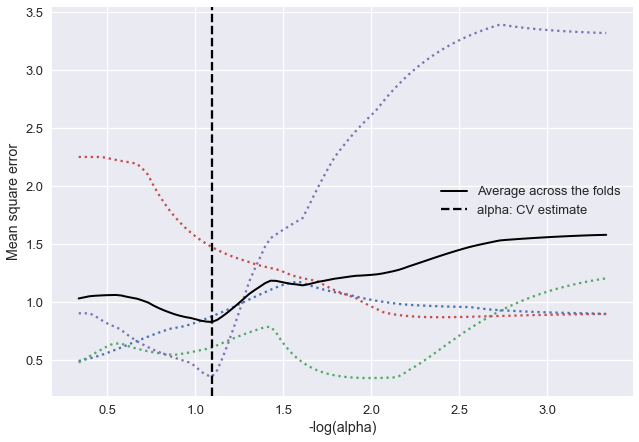

,0
cond,0.000000
tn,-0.018572
toc,-0.188953
mean,0.000000
cv,0.000000
n_hi_pulse_yr,0.334708
revs_per_yr,0.515279
range,0.000000
max10,-0.000000
max12,0.000000


In [21]:
# Best lasso using CV
params = ecoreg.best_lasso(df, resp_var, exp_vars, kcv=4, cv_path=True, hists=False)
params

In [22]:
###### OLS results for best lasso
res_lasso = best_lasso_ols(df, resp_var, params)
print ''
print_equation_string(res_lasso)

                            OLS Regression Results                            
Dep. Variable:               swim_div   R-squared:                       0.512
Model:                            OLS   Adj. R-squared:                  0.381
Method:                 Least Squares   F-statistic:                     3.929
Date:                Fri, 08 Dec 2017   Prob (F-statistic):             0.0224
Time:                        10:27:50   Log-Likelihood:                -62.866
No. Observations:                  20   AIC:                             135.7
Df Residuals:                      15   BIC:                             140.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       -26.8420     15.126     -1.775

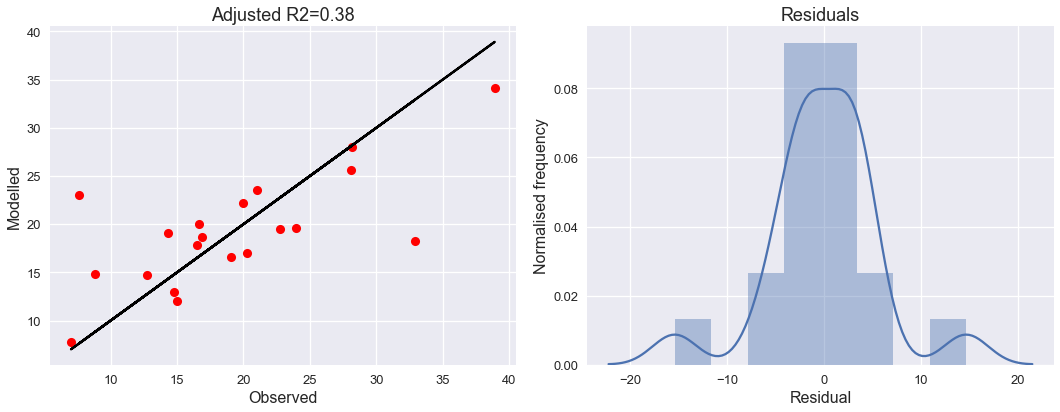

In [17]:
# Plot
plot_model(df, res_lasso, resp_var)

##### 4. Best subsets

In [18]:
# Best subsets regression
res_bss = ecoreg.best_subsets(df, resp_var, exp_vars)
print ''
print_equation_string(res_bss)

Regression results for the model with the lowest BIC:

                            OLS Regression Results                            
Dep. Variable:               swim_div   R-squared:                       0.423
Model:                            OLS   Adj. R-squared:                  0.355
Method:                 Least Squares   F-statistic:                     6.230
Date:                Fri, 08 Dec 2017   Prob (F-statistic):            0.00934
Time:                        10:26:24   Log-Likelihood:                -64.534
No. Observations:                  20   AIC:                             135.1
Df Residuals:                      17   BIC:                             138.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------

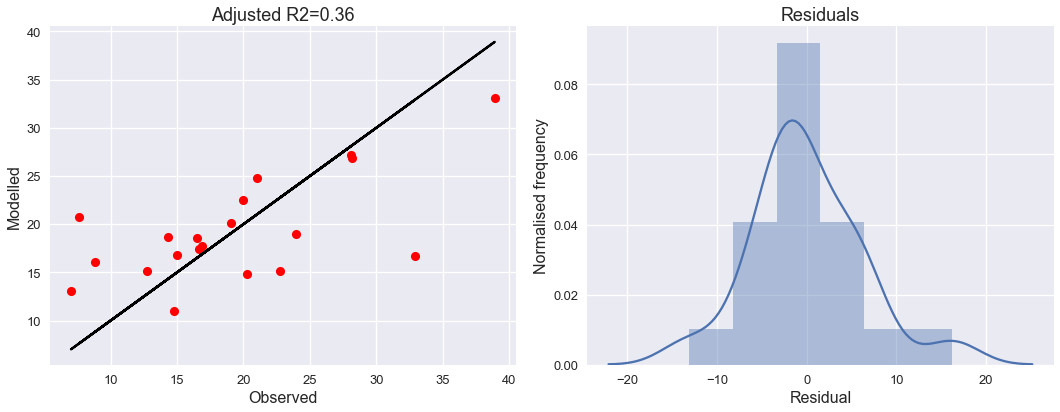

In [19]:
# Plot
plot_model(df, res_bss, resp_var)

## 8. Results

**Note:** Much of this is now out-of-date, but I'll leave it here as a reminder of what I looked at previously.

The Excel file here:

C:\Data\James_Work\Staff\Susi_S\ECOREG\regression_results_summary.xlsx

summarises the results, including details of the main regression relationships and additional comments to aid interpretation. Simplified summaries appear in the tables below.

### 8.1. Norway

<img src="https://github.com/JamesSample/ECOREG/blob/master/Images/nor_reg_results.png?raw=true" alt="Norway regression results" width="800">

### 8.2. Germany

<img src="https://github.com/JamesSample/ECOREG/blob/master/Images/ger_reg_results.png?raw=true" alt="Germany regression results" width="800">

### 8.3. Norway and Germany combined

<img src="https://github.com/JamesSample/ECOREG/blob/master/Images/all_reg_results.png?raw=true" alt="Combined regression results" width="800">

### 8.4. Interpretation

What does all this mean? Umm...

#### 8.4.1. PB responses

Pooling the data from both countries suggests a simple and statistically significant relationship between the overall PB metrics and TP. For PB richness:

$$pb_{richness} = 13.7*country - 0.02*tp + 9.0$$

and for PB abundance:

$$pb_{abundance} = 342*country - 0.59*tp + 208$$
  
where `country` is a binary variable with value 1 for Norway and 0 for Germany. 

The effect sizes here seem to be ecologically relevant: on average, Norwegian sites have around 14 additional species and abundance scores are 342 units higher than in Germany. In addition, in both locations, a change in TP concentrations of 100 units results in two fewer species and a decrease in abundance of around 59 units. TP scores in our dataset range from around 0 to 450, while richness scores range from 0 to ~35 and abundance scores from 0 to 1000, so these effect sizes are not negligible.

Unfortunately, **this relationship is entirely dependent on a single extreme measurement from Norway**, so it needs interpreting cautiously. Consider the plot below:

In [ ]:
# Plot pb_rich versus TP
cols = ['graz_scrap', 'country', 'cv']
df = pd.concat([site_df, mzb_df, hi_df], axis=1)[cols]
sn.lmplot(x='cv', y='graz_scrap', hue='country', data=df, 
          ci=95, size=8, markers='x', robust=True
          scatter_kws={'s': 100})

In [ ]:
# Plot pb_rich versus TP
cols = ['pb_rich', 'country', 'tp']
df = pd.concat([site_df, pb_df, hi_df], axis=1)[cols]
sn.lmplot(x='tp', y='pb_rich', hue='country', data=df, 
          ci=False, size=8, markers='x', 
          scatter_kws={'s': 100})

It is very clear that Norway has generally higher PB richness (and abundance) than Germany. There is also perhaps some weak evidence for a negative relationship between PB richness and TP in Germany (but it isn't significant by itself - see below). The main problem is that there is very little variation in TP for the Norwegain sites, except at a single location which has very high TP and low richness/abundance. 

Susi has analysed this sample twice to check there wasn't a mistake during processing and the high TP value does appear to be genuine. It's also interesting that this site is one of the few in Norway with low PB richness and abundance, and it's plausible that this is caused by (or at least associated with) the high TP concentrations. However, **we would need to find more Norwegian sites with high TP to test this hypothesis**.

**Addition:** In an e-mail received 09/03/2017 at 09:36, Susi suggested using log(TP) instead of TP. This **does not work as well as using TP directly**, but it's not a bad model: the BIC for `pb_rich ~ log(tp)` is 443.5, compared to 424.2 for `pb_rich ~ country + tp`. This difference is substantial difference, but if Susi has a strong ecological argument for a negative correlation specifically with log(TP), then we might be able to justify it. It's certainly more robust than the "best" two line fit, because it doesn't depend on just a single point.

$$pb_{richness} = -4.1log(TP) + 26.6$$

In [ ]:
mod_str = 'pb_rich ~ np.log(tp)'

# Regression. Pass alpha=0 for OLS. Larger alpha gives a bigger penalty on the
# size of the parameter estimates
model = smf.ols(mod_str, data=df).fit_regularized(alpha=0, l1_wt=0)

print model.summary()

# Plot
sn.lmplot(x='tp', y='pb_rich', data=df, logx=True,
          ci=False, size=8, markers='x', 
          scatter_kws={'s': 100})

Because the Norwegain and German sites are clearly different in terms of their PB richness and abundance, it perhaps makes more sense to consider the results obtained from the two countries separately:

 * In **Norway**, we find that no combination of the explanatory variables provides an adequate explanation for the variation in PB assemblages. The only factors that are close to being useful are **measures of flow variability** such as **range** and **coefficient** of variation, but these effects are inconsistent and are not always statistically significant. <br><br>
 
 * In **Germany**, there is less variation in PB assemblages (again, both richness and abundance), but more of that varaiation can be explained by the predictors in our dataset. The **number of high pulses per year** seems to have a consistent and significant effect on PB assemblages in Germany, and **conductivity** also seems to be a relevant in some cases (but to a lesser extent). Increases in either of these quantities are associated with decreases in PB richness and abundance. 
 
 High flow pulses are likely to be associated with increased scouring, so in this case a direct causal relationship seems plausible. Conductivity, on the other hand, seems more likely to have an indirect effect, perhaps acting as a proxy for the overall variety of dissolved chemical species? In our dataset, conductivity is fairly closely correlated with TN, TP, TOC and pH (see the matrix plot below) and an analysis of the lasso paths suggests that these separate chemical factors may become important as the statistical models are allowed to become more complex. However, in the simpler models favoured in this analysis, it is possible that conductivity is doing a reasonable job of summarising/integrating these various effects.

In [ ]:
# Correlation plot with cond for Germany
cols = ['cond', 'tn', 'tp', 'toc', 'ph', 'mean', 'cv', 
        'n_hi_pulse_yr', 'range', 'days_to_p05', 'days_to_p95', 
        'revs_per_yr', 'country', 'regulated']
df = pd.concat([site_df, pb_df, hi_df], axis=1)[cols]

# Either filter by country or convert country label to boolean
df = df.query('country == "D"')
#df['country'] = pd.Categorical(df.country).labels

# Calc corr matrix
corr = df.corr(method='spearman')

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(20, 20))

# Generate a custom diverging colormap
cmap = sn.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sn.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1,
           square=True, linewidths=.5, annot=True, 
           annot_kws={'fontsize':10}, fmt='.2f',
           cbar_kws={"shrink": .5}, ax=ax)

Note that, taken alone, there is no evidence from Germany or Norway for the simple relationship between PB assemblages and TP, as suggested by the pooled data analysis (see regression summary below for Germany). This means that either:

 * The relationship with TP is an "artifact" driven by a single extreme point in Norway, or <br><br>
 
 * Taken separately, Germany and Norway do not have sufficient PB and TP gradients to robustly detect the relationship, but using the pooled data a logarithmic relationship becomes apparent (see above).

In [ ]:
df = pd.concat([site_df, pb_df, hi_df], axis=1)

# Either filter by country or convert country label to boolean
df = df.query('country == "D"')

# Regression. Pass alpha=0 for OLS. Larger alpha gives a bigger penalty on the
# size of the parameter estimates
mod_str = 'pb_rich ~ tp'

model = smf.ols(mod_str, data=df).fit_regularized(alpha=0, l1_wt=0)

print model.summary()

##### Summary for PB

 * The best-fitting model using the pooled data suggests a statistically and ecologically significant inverse correlation between PB assemblages and TP i.e. more TP means lower PB richness and abundance. However, this result is hugely influenced by a single extreme data point in Norway. More data would be required to test this hypothesis further. <br><br>
 
 * An alternative model for the grouped data suggests a logarithmic relationship between PB assemblages and TP: species richness and abundance decay exponentially as TP increases. This model is statistically significant, but it is not as good as several of the other models considered. However, if Susi has an ecological mechanism that would fit this model, it may provide a more convincing explanation than the others.  
 
 * In Germany, there is clear evidence that more high flow pulses are associated with lower PB richness and abundance, most likely due to increased scouring. Note that in our hydrological metrics, high flow pulses are defined as flows greater than p95, and by definition these occur 5% of the time. In our dataset, "more high pulses" therefore actually means that high pulses are frequent but of *short duration* (rather than infrequent but sustained). In other words, more high pulses can be interpreted as "flashiness" in extreme flows. <br><br>
 
 * In Germany there is weaker evidence that higher conductivity equates to lower PB richness. I suspect that conductivity is an indirect effect i.e. it is acting as a proxy for a range of other pollutants (e.g. TP, TN, TOC, pH and others, some of which may not be in our dataset). 
 
 This seems reasonable. In statistics, we find that more complex models *always* provide a better fit to the calibration data, but "overfitting" typically leads to poor out-of-sample (i.e. validation) performance. As the amount of data increases, so does the information content of the measurments, which makes it possible to use more complex models *without* overfitting. As a result, the complexity of the "best" statistical model will generally increase with the data volume. 
 
 In this anlysis we have 65 sites (25 in Germany), which is not a lot in statistical terms. The information content of our data therefore precludes complex models - note that *all* the "good" models chosen via cross-validation in this analysis comprise only a few parameters. In this context variables such as conductivity, which integrate the effects of other variables (maybe?), are likely to be chosen as the best predictors in a simple model. Perhaps with more data, the impritance of conductivity would decrease and separate nutrients/other chemical species would become more significant?
 
#### 8.4.2. MZB responses

Perhaps the main picture that emerges from the MZB data is that the dominant drivers are hydrological, particularly those describing flow extremes. In the pooled dataset, key predictors include the **number of high pulses per year** (more pulses equates to lower MZB scores), the **number of flow reversals per year** (more reversals means lower scores) and the **amount of time elapsed since the last flow extreme** (longer periods to the last "flood" or "drought" event, as defined by e.g. min, max, p95 and p05, are generally associated with higher MZB scores). This seems fairly intuitive, because large flow events increase bed shear stresses and disrupt habitats, whereas drought conditions reduce the "wetted area" and therefore the extent of viable habitat - both factors that are likely to negatively affect MZB communities. Factors such as the range of flows and the mean flow are also relevant.

**NB:** What is an ecologically interesting change in the German Saprobic Index? In our dataset, values only range from 1.4 to 2.2, which doesn't seem very much. Is this change meaningful?

In Norway, there is a **clear relationship between TN concentrations and the number of taxa**. TN values in Norway range from around 0 to 0.5 mg-N/l, and the number of taxa lies between 0 and 50. The best fitting model indicates that every 0.1 mg-N/l increase in TN is typically associated with 4 to 5 additional taxa, so the effect size is not negligible. This pattern is not repeated in Germany, however, perhaps indicating that the Norwegian streams are N-limited, whereas in Germany the development of MZB communities is unconstrained by the availability of N in the food chain.

The only relationship observed between MZB and nutrients in Germany is a negative association between the LIFE Index and TP:

$$life_{idx} = -0.001tp + 7.8$$

However, the effect size is extremely weak, because the variation in LIFE scores in Germany is small (all values are between 7.3 and 8.2). I don't know what a one unti change in the LIFE score means ecologically, but presumably not very much? Accoridng to this relationship, a 500 ug-P/l change in TP (which is equal to the maximum range in our dataset) is associated with a 0.5 unit change in the LIFE score. I therefore suspect that this relationship is statistically but **not ecologically significant**.

##### Summary for MZB

Extreme flow events (droughts, floods) are inversely correlated with MZB scores, presumably due to disruption caused to MZB communities. In Norway, there is a positive relationship between the number of MZB taxa and TN, but this is not observed in Germany. Norwegian streams have much lower TN than in Germany (0 to 0.5 mg-N/l versus 1 to 6 mg-N/l), probably implying that MZB communities in Norwegian systems are limited by N availability, whereas this is not an issue in Germany.

### 9. Conclusion

These notebooks have attempted to link ecological indices (PB and MZB assemblages) to metrics representing water chemistry and hydrology for a range of regulated and unregulated rivers in both Norway and Germany. 

[Notebook 1](http://nbviewer.jupyter.org/github/JamesSample/ECOREG/blob/master/ecoreg_full_analysis_1.ipynb) first characterised the differing hydrological regimes in Norway versus Germany, and then applied PCA to identify a reduced set of explanatory and response variables representing ecology, water chemistry and hydrology in each country.

[Notebook 2](http://nbviewer.jupyter.org/github/JamesSample/ECOREG/blob/master/ecoreg_full_analysis_2.ipynb) used a robust Bayesian methodology to test for differences in the variables of interest between regulated and unregulated sites. As might be expected, the most significant differences were hydrological: flow variation is much lower at regulated sites compared to unregulated ones and the number of high flow events (> 95th percentile) is smaller. In Norway, there is also evidence that regulated sites have significantly higher concentrations of TN and TOC - most probably because the regulated sites are further downstream and are therfore likely to have greater nutrient inputs (e.g. from agriculture or urban areas).

Differences in ecological variables between regulated and unregulated sites are less clear. There is some evidence that regulated sites have greater PB abundance and richness, but this result has a (Bayesian) probability of around 85-90% and is therefore not significant at the traditional 95% level. The failure to identify differences in ecology between regulated and unregulated sites could have several explanations:

 1. **Flow regulation does not affect ecology**. This seems unlikely, and I believe it contradicts a lot of exisiting literature on this subject. <br><br>
 
 2. **Differences exist, but our data is insufficient to detect them with confidence**. This is possible, but our dataset is comparable to the best currently available. <br><br>
 
 3. **Differences exist, but the relationships are strongly non-linear and cannot be approximated by the linear methods considered here**. This is also possible, but we do not have time/resources to extend the analysis much further. <br><br>
 
 4. **There is no sharp distinction between "regulated" and "unregulated" sites in our dataset**. This seems quite likely based on what we know abotu these sites. Some "regulated" locations are only lightly impacted, whereas some of the "unregulated" sites are downstream of large lakes and their hydrological regime is therefore buffered to some degree. "Regulation" may therefore be better expressed as a continuous variable in our dataset, rather than a "hard" binary threshold.
 
To explore option 4 in more detail, this notebook has applied a variety of multiple linear regression techniques to explore relationships between water chemistry and hydrology explanatory variables and the ecological response. We find that a combination of PCA followed by lasso regression (with consideration of the lasso path) can provide more insight into the data than standard OLS approaches. The lasso is also more statistically defensible than commonly applied OLS methods such as best subsets or stepwise regression schemes.

We find that for PB the most convincing general relationship (i.e. regardless of country) is a negative association between PB richness/abundance and log(TP): increasing TP concentrations suggest exponentially decreasing PB richness and abundance. **Physical interpretation for log relationship from Susi?**

Within just the German dataset, we also see a clear indication that PB assemblages are negatively affected by extreme flow events such as the number of high pulses (>95th percentile) per year. We interpret this as a result of increased bed shear stress leading to scouring and disruption of benthic communities. There is also evidence in the German dataset that PB assembalges are inversely associated with conductivity. We interpret this as an indirect effect, where conductivity acts to effectively integrate or summarise the combined effects of various other water chemistry variables (pH, TP, TOC etc.) none of which are individually significant (at least, not given the data volume we currently have).

For MZB the most prominent general relations across both countries are that MZB communities are negatively affected by frequent flow extremes (both floods and droughts). In the Norwegian dataset, there is also clear evidence that increases in TN are associated with greater numbers of MZB taxa. This effect is not observed in Germany, where TN concentrations are an order of magnitude higher. One interpretation of this could be that MZB communities in Norway are limited by N availability, and are therefore ready to take advantage of any additional sources of N, whereas this is not the case in Germany.

Overall, our results suggest that the hydrological effects of moderate flow regulation (more stable flows, fewer extreme events etc.) may lead to greater richness and abundance of PB and MZB than would normally be found in natural systems. This analysis also tentatively suggests that, especially in low-nutrient systems such as Norway, the effects of changing water chemistry (not necessarily linked to flow regulation) may be equal to or greater than the influence of hydrology (??).